In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from celluloid import Camera
from IPython.display import HTML
from scipy.optimize import curve_fit
from tabulate import tabulate

Function to plot the edges of a cube with side length $L$ centered at $(0,0,0)$


In [17]:
def plot_cube(ax, L):
    """Plot the edges of a cube with side length L."""
    vertices = np.array([[-L/2, -L/2, -L/2], [L/2, -L/2, -L/2], [L/2, L/2, -L/2], [-L/2, L/2, -L/2],
                         [-L/2, -L/2, L/2], [L/2, -L/2, L/2], [L/2, L/2, L/2], [-L/2, L/2, L/2]])
    edges = [[vertices[0], vertices[1], vertices[5], vertices[4], vertices[0]],
             [vertices[1], vertices[2], vertices[6], vertices[5], vertices[1]],
             [vertices[2], vertices[3], vertices[7], vertices[6], vertices[2]],
             [vertices[3], vertices[0], vertices[4], vertices[7], vertices[3]]]
    edges_collection = Line3DCollection(edges, color='darkviolet')
    ax.add_collection3d(edges_collection)
    ax.set_xlim([-L/2, L/2])
    ax.set_ylim([-L/2, L/2])
    ax.set_zlim([-L/2, L/2])

    
    


<p>
<h1><b><center>Continuum Mechanics</center></b></h1>
<h2><b><center>Universidad de Antioquia</center></b></h1>
<h3><b><center>Gas Thermalization</center></b><h3>
</p>

<hr/>
<b>Name</b>: Alejandro Murillo González
<br/>
<b>DI</b>: 1007338060
<br/>


# Objective

The aim of this task is to simulate the *thermalization* process of a gas of monoatomic particles and to test some of the basic principles of statistical mechanics.

## Procedure

To achieve the objective:

1. Starting with the notebook developed in the Statistical Mechanics class, generate random positions for N point particles within a rectangular box of side length L.

2. For the velocities, initially assign all particles random velocities with the same magnitude, e.g., $v_{0}$ = 1 (in thermodynamic units).

3. Define a time step to simulate the movement of the particles as follows:

   - Calculate $L_{mol}$ in the box.
   - The time step will be $dt = (L_{mol}/v_0)/f_t$, where $f_t = 10$. You may adjust $f_t$ to be smaller or larger depending on how long the simulation takes to run.

4. Simulate the movement of the gas particles as follows:

   - For each time step, update the position of the particles based on the velocity each particle has at that given moment.
   - If a particle exits one side of the box, it should re-enter the box from the opposite side (periodic boundary conditions).
   - At each time step, and for each particle, determine which of the other particles in the box is closest. If the distance to the other particle is less than $L_{mol}/f_d$, where $f_d=10$, assume the two particles collide and calculate the outcome of the elastic collision between them. You can adjust the $f_d$ parameter according to the results.

5. Create a histogram of the particle speeds every 100 time steps and observe how the speed distribution changes as collisions occur.

6. When the velocity distribution resembles a Maxwell-Boltzmann distribution, we say that the simulation, or the gas, has thermalized. Determine the temperature and pressure of the gas using the laws discussed in class. Pressure does not need to be calculated using collisions; it can be determined using the relationship with the kinetic energy density.

## Expected Results

- This notebook with the procedure properly documented.

- Minimum plots:
  - Several plots showing the speed distribution of the particles during the simulation.

- Minimum data:
  - The temperature at the end of the simulation.
  - The pressure at the end of the simulation.

- Optional plots:
  - Animation of the gas particle movement.
  - Evolution of temperature as a function of time.
  - Evolution of pressure as a function of time.



# **Solución**

## 1. Positions


In [3]:

# Initialization
L = 10  # Cube side length in nanometers
N = 500  # Number of particles

np.random.seed(54645)  # Seed for reproducibility

# Initial positions and velocities
positions = pd.DataFrame(np.random.uniform(-L/2, L/2, size=(N, 3)), columns=['x', 'y', 'z'])


## 2. Velocities


In [5]:
# velocidades
v0 = 1  # Initial speed in UV
velocities = np.random.uniform(-1, 1, size=(N, 3))
norm_velocities = np.array([v/np.linalg.norm(v) for v in velocities]) * v0
positions[['vx', 'vy', 'vz']] = norm_velocities

Ei = 1/2 * sum(np.array([np.linalg.norm(i) for i in norm_velocities])**2)  # Initial kinetic energy



## 3. Time, unities and constants


To calculate $ L_{mol} $, let's define the thermodynamic units of the problem:

In [18]:
# Constants and unit conversions
kB = 1.38e-23  # Boltzmann constant [kg m^2 / (K s^2)]
UM = 1.66e-27  # Atomic mass unit [kg]
UL = 1e-9  # Length unit [meters (nanometers)]
UT = 300  # Temperature unit [Kelvin]
Ut = np.sqrt(UM * UL**2 / (UT * kB))  # Time unit [s]
UV = UL / Ut  # Speed unit [m/s]

URHO = UM/UL**3
UE = UM*UV**2
UF = UM*UL/Ut**2
UP = UF/UL**2

mA = 1 # Particles mass in UM



V = L**3     # Box volume
n = N/V         # Particle Densities
rho = n*mA


## 4. Collisions between particles and simulation

$L_{mol}$

In [19]:
Vmol = mA / rho  # Molecular volume
Lmol = Vmol**(1/3)  # Molecular length scale


In [20]:
# Time step
ft = 10
dt = Lmol / (v0 * ft)  # Time step [s]


### 4.1 Theory for Elastic Collisions Between Particles

We assume two particles with equal mass $m = 1$ moving with velocities $\vec{v_i}$, $\vec{v_j}$, and positions $\vec{r_i}$, $\vec{r_j}$. The particles collide when $|\vec{r_i} - \vec{r_j}| < 2R$, where $R$ is their radius (assuming all particles have the same $R$).

When the particles collide, they exchange momentum $\vec{p}$:

$$
\vec{v_i} \rightarrow \vec{v_i} + \frac{\vec{p}}{m_i} \quad \text{[1]}
$$

$$
\vec{v_j} \rightarrow \vec{v_j} - \frac{\vec{p}}{m_j} \quad \text{[2]}
$$

Since the collision is elastic, the kinetic energy is conserved:

$$
\frac{1}{2}m_i {v_i}^2 + \frac{1}{2}m_j {v_j}^2 = \frac{1}{2}m_i \left|\vec{v_i} + \frac{\vec{p}}{m}\right|^2 + \frac{1}{2}m_j \left|\vec{v_j} - \frac{\vec{p}}{m}\right|^2
$$

We will only consider the specular collision, where $\vec{p}$ is normal to the reflection plane:

$$
\vec{p} = p\ \hat{r}_{ij}
$$

$$
\hat{r}_{ij} = \frac{\vec{r_i} - \vec{r_j}}{|\vec{r_i} - \vec{r_j}|}
$$

$\hat{r}_{ij}$ is a unit vector defined by the vector from the center of one particle to another.

Solving for $\vec{p}$ using the above equations, we obtain:

$$
\vec{p} = -2\frac{m_i m_j}{m_i + m_j}[(\vec{v_i} - \vec{v_j}) \cdot \hat{r}_{ij}]\hat{r}_{ij}
$$

Substituting $\vec{p}$ into equations $[1]$ and $[2]$, we obtain the final velocities of the particles.
```

In [21]:
def collision(ri, rj, vi, vj):
    """Compute post-collision velocities for two colliding particles."""
    r = ri - rj
    n = r / np.linalg.norm(r)
    v_rel = vi - vj
    vn = np.dot(v_rel, n) * n
    v1 = vi - vn
    v2 = vj + vn
    return v1, v2


Calculation of the minimum collision distance

In [22]:
# Collision radius
fd = 10
R = np.round(Lmol / fd, 3)

Maxwell-Boltzmann distribution for data fitting:

In [24]:
def maxwell_boltzmann(v, A, T):
    """Maxwell-Boltzmann distribution for fitting velocity data."""
    return A * np.sqrt(2 / np.pi) * (v**2) * np.exp(-v**2 / (2 * T))


### 4.2 Collision Simulation and Maxwell-Boltzmann Histogram Fitting

In [25]:



fig = plt.figure(figsize=(12, 6)) 
ax1 = fig.add_subplot(1, 2, 1, projection='3d') 
ax2 = fig.add_subplot(1, 2, 2)  
ax1.set_xlabel("$X\ [nm]$")
ax1.set_ylabel("$Y\ [nm]$")

ax2.set_xlabel("$V\ [UV]=[1573 m/s]$")
ax2.set_ylabel("Probability Density")


ax1.set_title(rf"Gas Thermalization, N={N}, ft={ft}, fd={fd},R={R} ",size=15)
ax2.set_title(rf"Velocity Histogram, $V_o$={v0*1573}[m/s] ",size=15)


camera = Camera(fig)



time = 500 # Simulatiom time in UT
cont = 0

# Arrays to save data of temperature, pressure and average velocitie
temp=np.zeros([time])
pres=np.zeros([time])
vp = np.zeros([time])


for i in range(time):
    
    # The particles start with uniform rectilinear motion
    positions["x_new"] = positions.x + positions.vx * dt
    positions["y_new"] = positions.y + positions.vy * dt
    positions["z_new"] = positions.z + positions.vz * dt
    
    # Periodic boundary conditions are applied
    positions[["x", "y", "z"]] = (positions[["x_new", "y_new", "z_new"]] + L/2) % L - L/2
    
    plot_cube(ax1, L)  # Plot of the cube edges (limits)

    # Positions and velocities are stored at each time step in arrays
    pos=np.array(positions[["x","y","z"]])        
    vel=np.array(positions[["vx","vy","vz"]])
    
    # Calculation of the average speed for the temperature
    positions["v"] = np.array([np.linalg.norm(i) for i in vel])
    vprom = np.average(positions.v*UV)
    vp[i]=vprom
    
    # Calculation of the temperature and pressure as a function of the average speed of the particles
    T = np.round(np.pi*UM*vprom**2/(8*kB),4)
    P = np.round(n/3 *UM/(UL**3)*vprom**2,4)
    
    # Temperature and pressure values are stored for later plotting
    temp[i]=T
    pres[i]=P
 
 
    
    """ Loop for distance calculation to determine if there is a collision, set as the minimum distance """

    for j in range(N):
        for k in range(N):
            if j!=k:
                dist=np.linalg.norm(pos[j]-pos[k])
                if dist<=2*R and j<k  :
                    # The velocities of the particles that collided are updated
                    vf1,vf2 = collision(pos[j],pos[k],vel[j],vel[k])
                    positions.loc[j,["vx","vy","vz"]]= vf1
                    positions.loc[k,["vx","vy","vz"]]= vf2
                   

                   
                    
 
    # The positions are plotted
    
    ax1.scatter(positions.x, positions.y, positions.z, color="dodgerblue",s=50)
    
    """Histogram and Maxwell-Boltzmann fit"""
    # This condition is added because at t=0 all particles have the same speed, and the histogram collapses

    
    if cont>=2:
        # data histogram
        hist, bin_edges = np.histogram(positions.v, bins=10, density=1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit
        params, covariance = curve_fit(maxwell_boltzmann, bin_centers, hist, p0=[1, 1])
        A_fit, T_fit = params

        # Data fit
        # Graph
        ax2.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], label="Data",color="dodgerblue")
        ax2.plot(bin_centers, maxwell_boltzmann(bin_centers, A_fit, T_fit), color="darkmagenta", label="Fit")
       

    ax2.grid(alpha=0.5)
    plt.tight_layout()
    

    for i in np.arange(0,time,100):
        if cont==i:
            ax2.get_figure().savefig('hist:'+""+str(i))
            
    camera.snap()
    cont+=1
    
    
    

plt.close()

animation = camera.animate(interval=60)

# Mostrar la animación
HTML(animation.to_html5_video())

                   
      

To determine how well the data fit the Maxwell-Boltzmann distribution, the $R^2$ test was used, where $0 < R^2 < 1$. A value in this range indicates that the fitting model explains part of the variability in the observed data. The closer $R^2$ is to 1, the better the model fits the data. If it is closer to 0, the fit is less adequate.

In [26]:
from sklearn.metrics import r2_score
r_squared = r2_score(hist,maxwell_boltzmann(bin_centers, A_fit, T_fit) )
r_squared

0.9799248101032303

It is observed that the obtained value is very close to 1, allowing us to conclude that the gas has indeed thermalized, and the values of temperature and pressure obtained once thermalization is reached are reliable.



## 6. Graphs of Temperature and Pressure as a Function of Time

### 6.1 Temperature, Pressure, and Final Velocity

Two measurements of the temperature are obtained: one is given by the Maxwell-Boltzmann fit coefficient when the gas has thermalized, and the other is the temperature measurement from the average velocity of the particles:
$$
T = \frac{\pi}{8 k_b} \langle v \rangle^2
$$

In [27]:
print(rf"Temperature with M-B fit: {np.round(T_fit*UT,2)} [°K]")
print(rf"Temperature from kinetic energy: {np.round(temp[-1],2)} [°K]")

Temperature with M-B fit: 103.38 [°K]
Temperature from kinetic energy: 101.87 [°K]


It is observed that there is a difference between the temperatures obtained from the fit and from kinetic energy. This may be due to the fact that the temperature from the fit represents the ideal temperature if the velocity distribution perfectly matched the Maxwell-Boltzmann distribution. However, while the fit has an $R^2$ indicating a good fit, it is not perfectly equal due to the numerical simulation being susceptible to calculation errors.


The pressure is obtained by:
  $$ P = \frac{n}{3} \langle v\rangle²$$



In [28]:
print(rf"The pressure of thermalized gas is: {np.round(pres[-1]/1e3,2)} [kPa] = {np.round(pres[-1]/101300,2)} [Atm]")


The pressure of thermalized gas is: 596.62 [kPa] = 5.89 [Atm]


The most probable speed of the particles, \( v_p \), can be calculated from the temperature found with the Maxwell-Boltzmann fit. It is defined as:

$$v_p = \sqrt{\frac{2 k_b T}{m}}$$

In [29]:
print(rf"The most probably velocity is: {np.round(np.sqrt(2*kB*T_fit*UT/UM),2)} [m/s]")

The most probably velocity is: 1311.06 [m/s]


Se observa que la rapidez más probable de las partículas es menor a la velocidad inicial de todas las partículas que era 1579.23 [m/s], esto debido a la termalización del gas producto de las colisiones.

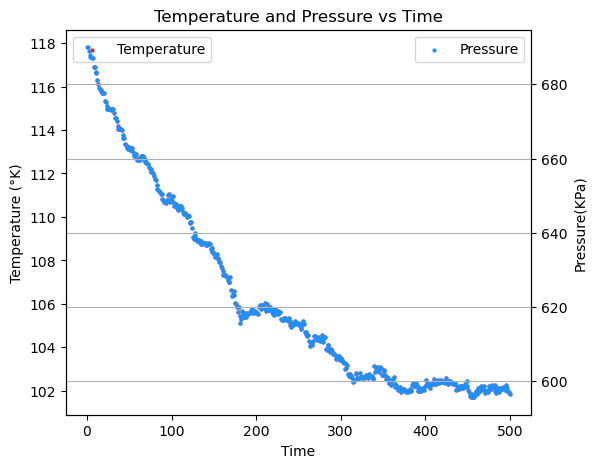

In [30]:
import matplotlib.pyplot as plt
tiempo=np.linspace(0,time,time)

fig, ax1 = plt.subplots(figsize=(6, 5))


ax1.scatter(tiempo, temp, marker='o', color='tab:red', label='Temperature',s=4)
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°K)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.scatter(tiempo, pres/1e3,color="dodgerblue", label='Pressure',s=4)
ax2.set_ylabel('Pressure(KPa)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')


plt.title('Temperature and Pressure vs Time')


plt.grid(True)
plt.show()


## 7. Energy Conservation

Previously, the sum of the initial kinetic energy of all particles, $ E_{i} $, was calculated. This will be the initial total mechanical energy of the system, as there are no potential energies. Once the gas has thermalized, the total mechanical energy $ E_{f} $ is recalculated:







In [31]:
Ef =1/2*np.sum(np.array([np.linalg.norm(i) for i in vel])**2)
print (rf"Initial Energy: {Ei}")
print (rf"Final Energy: {Ef}")

Initial Energy: 250.0
Final Energy: 248.39780821621505


It is verified that the system's energy is not perfectly conserved. This is due to a curious behavior observed in the particles during collisions. Under certain conditions of low velocity and proximity, the particles would end up orbiting each other. Attempts were made to modify this behavior in various ways. The approach that eliminated this behavior was to adjust the $fd$ and $ft$ parameters. However, this change increased the computational cost and simulation time. Therefore, it was decided not to apply this modification and to keep the $fd$ and $ft$ values at their optimal levels to optimize the simulation.
